In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.ensemble import RandomForestClassifier
import kagglehub
import os
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
np.random.seed(222)

In [4]:
# Download latest version
path = kagglehub.dataset_download("kooaslansefat/siemens-dependable-ai-challenge")
print("Path to dataset files:", path)
gray_cmap = LinearSegmentedColormap.from_list('gy', [(.3,.3,.3),(.8,.8,.8)], N=2)

100%|██████████| 508k/508k [00:00<00:00, 64.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kooaslansefat/siemens-dependable-ai-challenge/versions/1


In [5]:
def set_plot_style():
  plt.axis([-2,2,-2,2])
  plt.xlabel('x1')
  plt.ylabel('x2')

In [6]:
file_list = os.listdir(path)
print("Files in the dataset directory:", file_list)
csv_file_path = os.path.join(path, 'trainingdata_a.csv')
df = pd.read_csv(csv_file_path, header='infer')
display(df.head())

Files in the dataset directory: ['trainingdata_b.csv', 'trainingdata_a.csv', 'trainingdata_c.csv']


,x1,x2,y
0,0.780742,0.412337,0
1,0.623970,0.940464,0
2,0.891573,0.435562,0
3,0.590270,0.586359,1
4,0.903968,0.631883,0


In [7]:
X = df[['x1', 'x2']].values
y = df['y'].values
X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)
X = (X - X_mean) / X_std ## Standarization of data

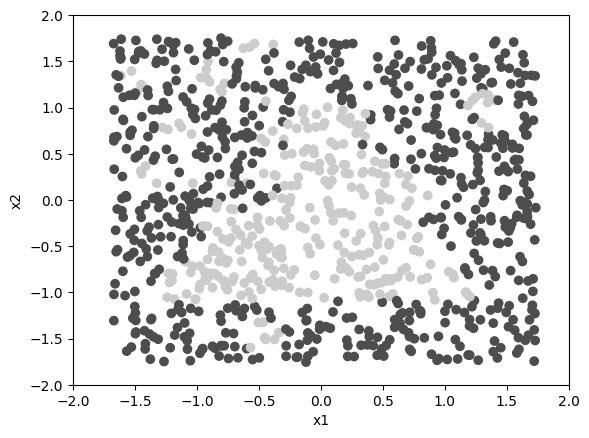

In [8]:
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)

In [9]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, y)

RandomForestClassifier()

In [10]:
#Function to create a mesh grid
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

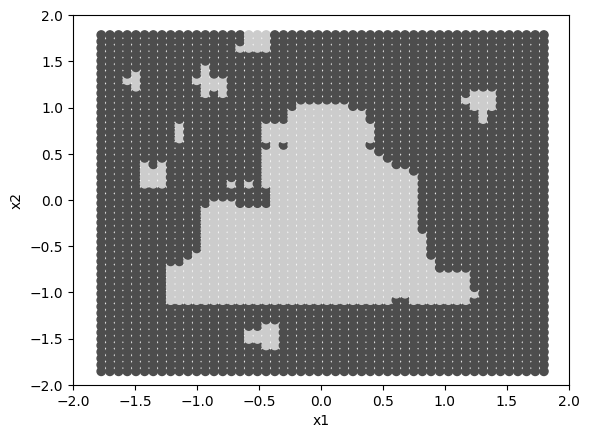

In [11]:
XX = make_meshgrid(X[:,0], X[:,1],h=.07)
yy = classifier.predict(XX)
set_plot_style()
plt.scatter(XX[:,0], XX[:,1], c=yy, cmap=gray_cmap)

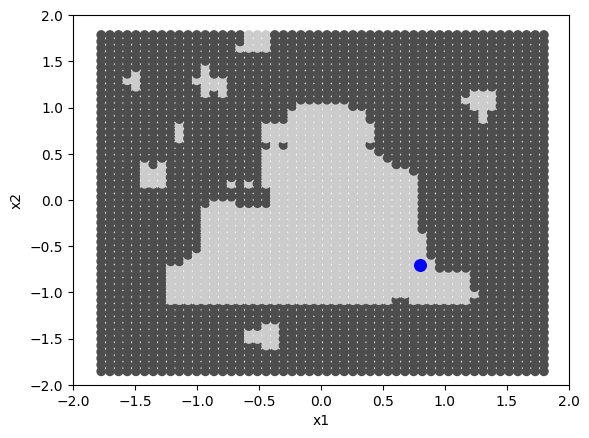

In [12]:
Xi = np.array([0.8, -0.7])
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

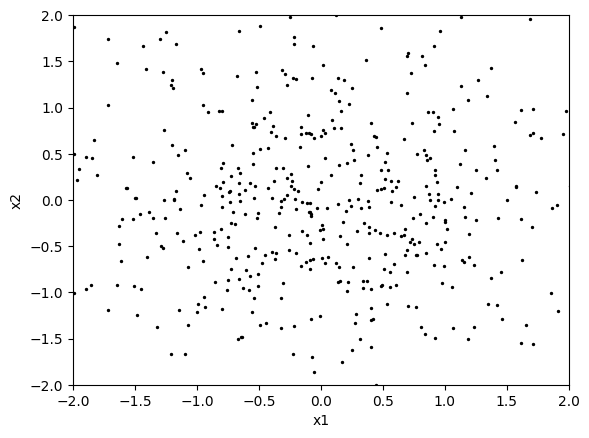

In [13]:
num_perturb = 500
X_lime = np.random.normal(0,1,size=(num_perturb, X.shape[1]))
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1], s=2, c="black")

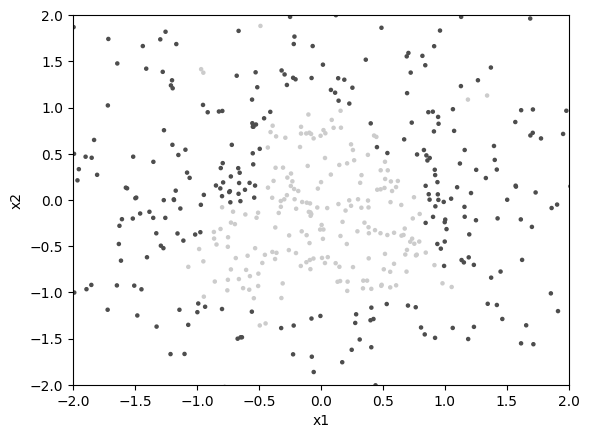

In [14]:
y_lime = classifier.predict(X_lime)
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1], s=5, c=y_lime, cmap=gray_cmap)

In [ ]:
classifier.predict(Xi.reshape(1, -1))

array([1])

In [15]:
kernel_width = 0.2
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

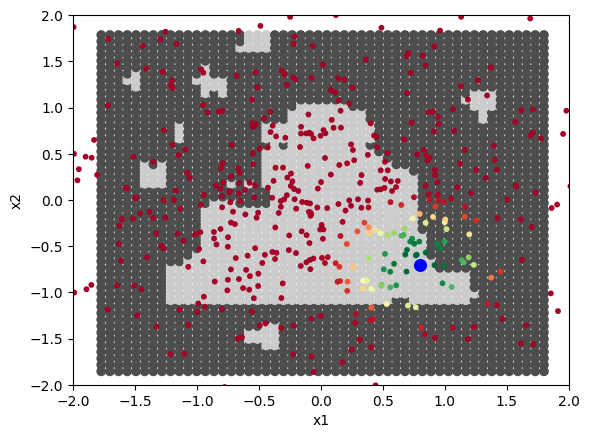

In [16]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn")
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

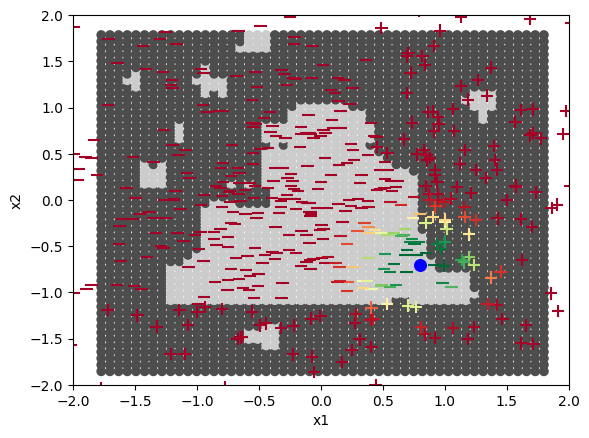

In [18]:
classifier.fit(X_lime, y_lime, sample_weight=weights)
y_limemodel = classifier.predict(X_lime)
y_limemodel = y_limemodel < 0.5

set_plot_style()
plt.scatter(XX[:,0], XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0], Xi[1], c="blue", marker="o", s=70)
plt.scatter(X_lime[y_limemodel==0,0], X_lime[y_limemodel==0,1], c=weights[y_limemodel==0], cmap="RdYlGn", marker="_",s=80)
plt.scatter(X_lime[y_limemodel==1,0], X_lime[y_limemodel==1,1], c=weights[y_limemodel==1], cmap="RdYlGn", marker="+",s=80)